In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.special import gamma, binom
from scipy.sparse import diags, kron, block_diag
from scipy.sparse.linalg import spsolve, eigs
from scipy.optimize import fsolve
from scipy.linalg import lstsq

def compute_classical_energy(u, eps, h):
    """Compute the discrete energy :

    Parameters
    ----------
    u : 2D-array
        The numerical solution of u.
    eps : float
        The diffusion coefficient.
    h : float
        The mesh size of x and y direction.

    Returns
    -------
    float
        The discrete energy of u.
        
    """
    
    ux = np.gradient(u)/h
    term1 = np.sum((eps**2 / 2.0) * (ux**2))
    term2 = np.sum(((1 - u ** 2) ** 2) / 4)
    return h * (term1 + term2)

def set_coef(terminate_point, alpha, method='L1'):
    """Set the coefficient of fractional scheme:

    Parameters
    ----------
    terminate_point : int
        The number of coefficient.
    alpha : float
        The fractional order between (0,1).
    method : str 
        The coefficient of scheme to generate.
        (defualt is 'L1')
        possible options : 'L1', 'GL'.

    Returns
    -------
    1D array
        The coefficient array generated 
        based on the selected method.
        
    """
    
    if method == 'L1':
        coef = [(j)**(1-alpha) - (j-1)**(1-alpha) \
                for j in range(1, terminate_point+1)]
    elif method == 'GL':
        coef = [(-1)**(j) * binom(alpha, j) \
                for j in range(0, terminate_point+1)]
        
    return np.array(coef)

def set_Laplacian2D(Nx, h, BC='periodic'):
    """Set the 2D discrete laplacian by central difference:
        Neumann boundary laplacian is discreted by 
        
        x-direction : u_{-1,j,k}=u_{0,j,k} and
                      u_{Nx+1,j,k}=u_{0,j,k}
                          
        y-direction : u_{i,-1,k}=u_{i,0,k} and
                      u_{i,Nx+1,k}=u_{i,0,k}
            
        Built by two block matries and two off-diagnoals, 
        corner block (corB), central block (cenB)
            
        The diagonal block is [corB, cenB, ..., cenB, corB]
        The off-diagnoals are diagonals line below (above) 
        the main diagonal by Nx positions, all consisting of 1.
            
        L = diagonal block + off-diagonals

    Parameters
    ----------
    Nx : int
        The number of mesh grids.
    h : float
        The mesh size.
    BC : str
        The boundary condition. (default is 'periodic')
        possible options : 'periodic', 'nuemann'

    Returns
    -------
    2D array
        The discrete laplacian with certain boundary.
        
    """
    if BC == 'periodic':
        diag = np.ones(Nx-1)
        L = diags([diag, -2*diag, diag, 1, 1], \
                  [-1, 0, 1 , -Nx+1, Nx-1], shape=(Nx-1, Nx-1))
        I = diags(diag, shape=(Nx-1, Nx-1))
    
        L = kron(L, I) + kron(I, L)
        
    elif BC == 'neumann':
        # bulid the block
        diag_cor = 3*np.ones(Nx)
        diag_cor[0] = diag_cor[-1] = 2

        diag_cen = 4*np.ones(Nx)
        diag_cen[0] = diag_cen[-1] = 3

        off_I = diags([np.ones(Nx**2), np.ones(Nx**2)], \
                      [Nx,-Nx], shape=(Nx**2, Nx**2))

        corB = diags([np.ones(Nx), -diag_cor, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        cenB = diags([np.ones(Nx), -diag_cen, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        diagBs = [cenB for i in range(Nx-2)]
        diagBs = tuple([corB]+diagBs+[corB])

        L = block_diag(diagBs) + off_I
        
    return L / h**2

In [60]:
dt = 5*1e-3
3000*dt

15.0

alpha: 0.1
alpha: 0.3
alpha: 0.5
alpha: 0.7
alpha: 0.9
alpha: 1


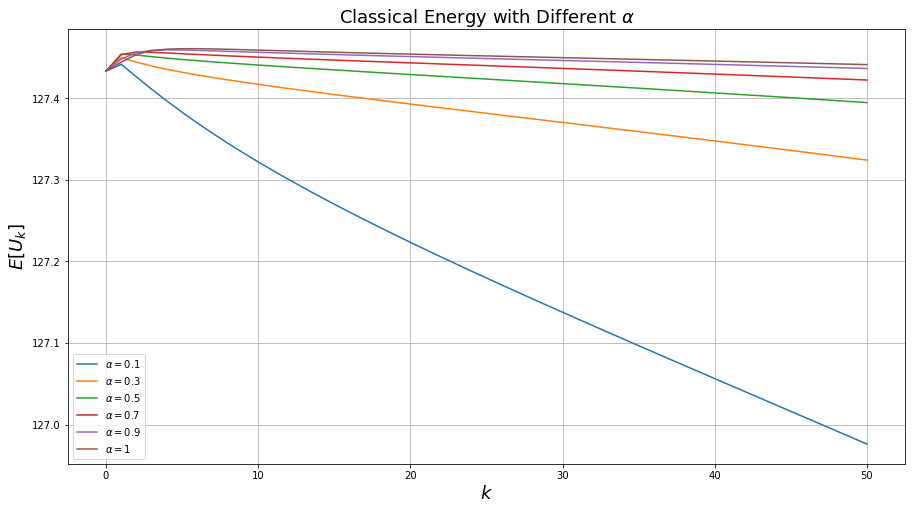

In [3]:
# L1 method
# set the fractional order in list to compute
# alpha_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
alpha_list = [0.1, 0.3, 0.5,  0.7, 0.9, 1]
# boundary condition
BC = 'periodic'

# the width of interface
eps = 0.1
# eps = 1

# define the saptial domain
# L = 10
L = 2
# determine the number of point in x or y direction
Nx = 2**8
x = np.linspace(-L/2, L/2, Nx) 
y = np.linspace(-L/2, L/2, Nx)

# compute the mesh size
h = L / (Nx - 1)
dt = 5*1e-3
iter_max = 50

# set the discrete laplacian
Lap = set_Laplacian2D(Nx, h, BC)

if BC == 'periodic':
    x = x[:-1]
    y = y[:-1]
    I = diags(np.ones((Nx-1)**2), shape=((Nx-1)**2, (Nx-1)**2))
elif BC == 'neumann':
    I = diags(np.ones((Nx)**2), shape=((Nx)**2, (Nx)**2))

# set the 2D mesh grid by x and y
X, Y = np.meshgrid(x, y)

# nonsmooth test
# u = 0.05*(2*np.random.rand(Nx-1, Nx-1)-1)

# smooth test
# u = np.tanh((1-((X)**2+(Y)**2))/5)*0.2
u = np.tanh((L**2/(2*np.pi)-((X)**2+(Y)**2))/5)*0.2

# turn 2D array into 1D array
u0 = u.flatten()


# the dicitionary to storage the different fractional order results
data_dict = {}

# set a figure to plot the energy in different alpha
fig = plt.figure(figsize=(15,8))

for alpha in alpha_list:
    print(f"alpha: {alpha}")
    # compute the first energy then store in the list
    energy_list = [compute_classical_energy(u0, eps, h)]
    
    # inital the history array
    u_historyArray = u0
    u = u0
    
    if alpha == 1:
        # solved by classical allen cahn
        H = (2+1/dt) * I - eps**2 * Lap
        
        for i in range(iter_max):
            b = (3+1/dt)*u - u**3
            u = spsolve(H, b)
            energy = compute_classical_energy(u, eps, h)
            energy_list.append(energy)
            u_historyArray = np.vstack([u_historyArray, u])
        
    else:
        L1_coef = set_coef(iter_max, alpha, 'L1')/ dt**alpha / gamma(2-alpha)
        H = (L1_coef[0]+2) * I - eps**2 * Lap
        
        for i in range(iter_max):
            if i == 0: # first iteration u_1
                b =  (3 + L1_coef[0])*u - u**3
                u = spsolve(H, b)
            else:
                u_nonlocalDiff = np.flipud(np.diff(u_historyArray, axis=0))
                u_nonlocal = L1_coef[1:i+1].dot(u_nonlocalDiff)
        
                b = (3 + L1_coef[0])*u - u**3 - u_nonlocal
                u = spsolve(H, b)
            
            energy = compute_classical_energy(u, eps, h)
            energy_list.append(energy)
    
            u_historyArray = np.vstack([u_historyArray, u])
    
    
    data_dict[alpha] = u_historyArray
    
    # plot the energy for k=0,...,N_t
    plt.plot(energy_list)
    
plt.legend([r"$\alpha=$"+f"{alpha}" for alpha in alpha_list])
plt.title(r"Classical Energy with Different $\alpha$", fontsize=18)
plt.xlabel(r"$k$", fontsize=18)
plt.ylabel(r"$E[U_{k}]$", fontsize=18)
plt.grid()
plt.show()

In [3]:
# load the previously computational result
from pathlib import Path
import numpy as np

# option: 'circle', 'coarsening'
testName = 'coarsening'

rootPath = Path('./data')
dataPath = [p for p in rootPath.iterdir() \
            if testName in str(p)]

data_dict = {}
# alpha_list = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
for pathName in dataPath:
    method = pathName.stem.split('_')[0]
    order = pathName.stem.split('_')[1]
    
    data_dict[float(order)] = np.load(pathName)

In [5]:
# set the mass array
DifferenceMass = []
maxDiff = []
for alpha in alpha_list:
    mass = [np.sum(_) for _ in np.diff(data_dict[alpha], axis=0)]
#     print(np.where(np.abs(mass)==max(np.abs(mass)))[0][0])
#     Maxidx = np.where(np.array(mass) == np.amax(np.abs(np.array(mass))))
#     maxDiff.append(np.where(np.abs(mass)==max(np.abs(mass)))[0][0])
    DifferenceMass.append(mass)
    
DifferenceMass = np.column_stack(DifferenceMass)
DifferenceMass.shape
# Y = np.sign(Y)*np.log10(np.abs(Y))

(3000, 6)

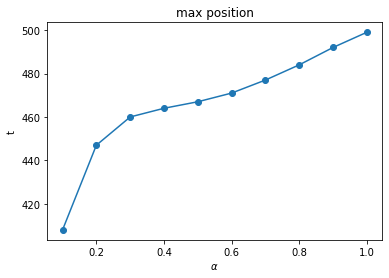

In [378]:
plt.plot(alpha_list,maxDiff, 'o-')
plt.xlabel(r'$\alpha$')
plt.ylabel('t')
plt.title('max position')
plt.show()

In [133]:
t = np.linspace(1,2000, 2000)
M = np.column_stack((np.ones(2000),t))

p, res, rnk, s = lstsq(M, Y)

In [405]:
DifferecneMass

array([[-0.23885472, -0.08998878, -0.02557336, -0.00676705, -0.00182019,
        -0.00096058],
       [-0.19420492, -0.05286876, -0.01624317, -0.00527431, -0.00169364,
        -0.00096159],
       [-0.16317052, -0.03777148, -0.01265356, -0.00459071, -0.00162563,
        -0.0009626 ],
       ...,
       [-0.02215067, -0.00943717, -0.00568736, -0.00399244, -0.00303868,
        -0.00270447],
       [-0.02216308, -0.00944563, -0.00569281, -0.0039964 , -0.00304177,
        -0.00270726],
       [-0.0221755 , -0.0094541 , -0.00569827, -0.00400035, -0.00304486,
        -0.00271005]])

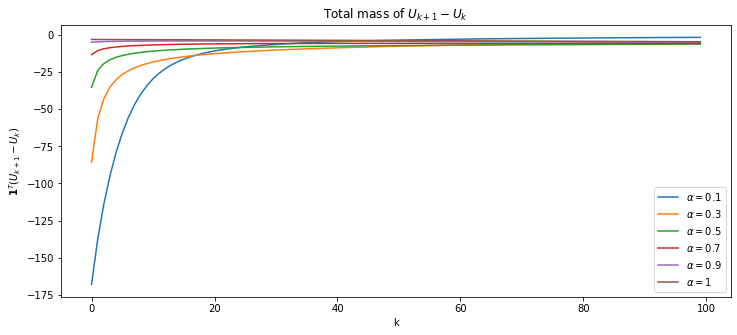

In [39]:
plt.figure(figsize=(12,5))
plt.title(r'Total mass of $U_{k+1}-U_k$')
plt.xlabel('k')
plt.ylabel(r'$\mathbf{1}^T(U_{k+1}-U_k)$')
plt.plot(DifferenceMass[:100])
plt.legend([rf"$\alpha=${alpha}" for alpha in alpha_list])
plt.show()

In [105]:
DifferenceMass[:,].shape

(5000, 6)

peak_prominesnce:  [0.34278983]
peak position:  [662]
widths:  [2083.54990333]
contour_heights: [0.15528866]


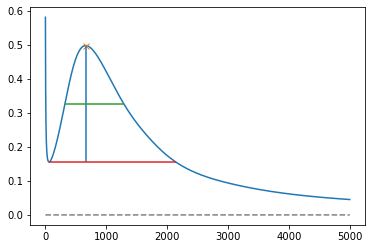

peak_prominesnce:  [0.73846117]
peak position:  [873]
widths:  [3970.97375694]
contour_heights: [0.05577211]


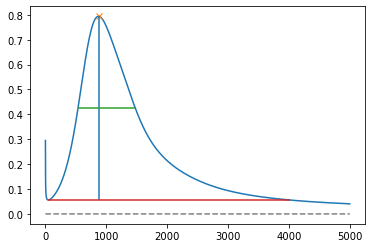

peak_prominesnce:  [0.93031065]
peak position:  [969]
widths:  [4857.16659192]
contour_heights: [0.04537747]


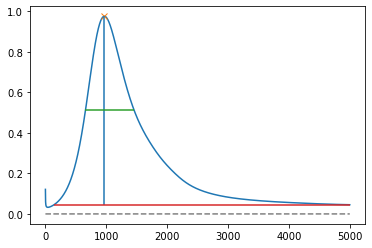

peak_prominesnce:  [1.07749337]
peak position:  [1036]
widths:  [4789.05451434]
contour_heights: [0.04461853]


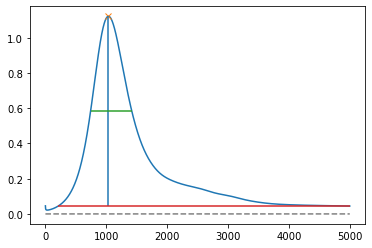

peak_prominesnce:  [1.1879709  0.00228275 0.00345097]
peak position:  [1083 3170 4084]
widths:  [4667.32367916  592.6501432   466.06736563]
contour_heights: [0.06352093 0.10243669 0.0795418 ]


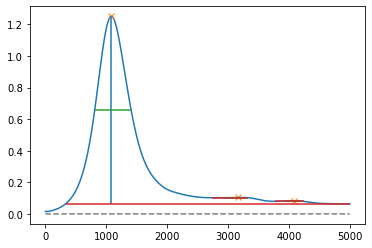

peak_prominesnce:  [1.24123956e+00 8.01301958e-03 2.89276432e-03 6.69569630e-04]
peak position:  [1102 3231 4090 4703]
widths:  [4619.33859492  638.5692523   557.72841278  305.78336173]
contour_heights: [0.0730032  0.10496529 0.07786926 0.07664012]


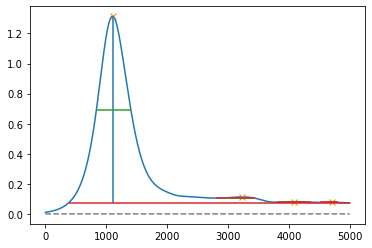

In [8]:
from scipy.signal import find_peaks, peak_prominences, peak_widths

peak_list = []
prominences_list = []
width_list = []


for Dm in np.transpose(DifferenceMass):
    if any(Dm < 0) is True:
        Dm = -Dm
    peaks, _ = find_peaks(Dm, height=0)
    prominences = peak_prominences(Dm, peaks)[0]
    results_half = peak_widths(Dm, peaks, rel_height=0.5)
    contour_heights = Dm[peaks] - prominences
    results_full = peak_widths(Dm, peaks, rel_height=1)
    print('peak_prominesnce: ', prominences)
    print('peak position: ', peaks)
    print('widths: ', results_full[0])

    plt.plot(Dm)

    plt.plot(peaks, Dm[peaks], "x")
    print('contour_heights:', contour_heights)

    plt.vlines(x=peaks, ymin=contour_heights, ymax=Dm[peaks])

    plt.plot(np.zeros_like(Dm), "--", color="gray")
    plt.hlines(*results_half[1:], color="C2")

    plt.hlines(*results_full[1:], color="C3")
    plt.show()
    peak_list.append(np.min(peaks))
    prominences_list.append(np.max(prominences))
    width_list.append(np.max(results_full[0]))

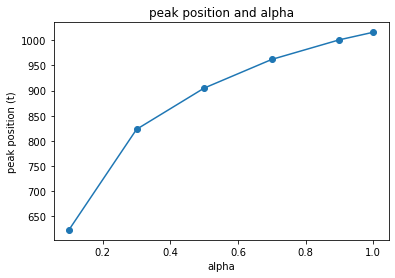

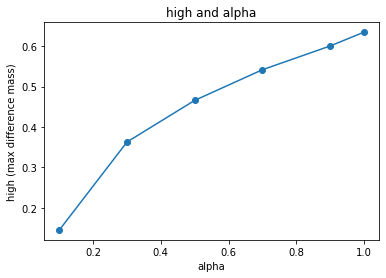

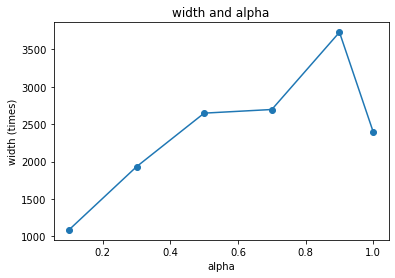

In [122]:
plt.plot(alpha_list, peak_list, '-o')
plt.xlabel('alpha')
plt.ylabel('peak position (t)')
plt.title('peak position and alpha')
plt.show()

plt.plot(alpha_list, prominences_list, '-o')
plt.xlabel('alpha')
plt.ylabel('high (max difference mass)')
plt.title('high and alpha')
plt.show()

plt.plot(alpha_list, width_list, '-o')
plt.xlabel('alpha')
plt.ylabel('width (times)')
plt.title('width and alpha')
plt.show()

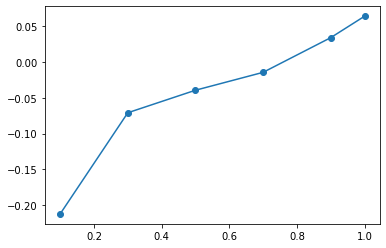

In [50]:
# plt.plot(alpha_list, p[0], '-o')
plt.plot(alpha_list, p[2], '-o')
# plt.plot(alpha_list, p[2], '-o')

In [94]:
Y = np.column_stack([mass_1, mass_2, mass_3, mass_4, mass_5, mass_6])

# Y = np.sign(Y)*np.log10(np.abs(Y))

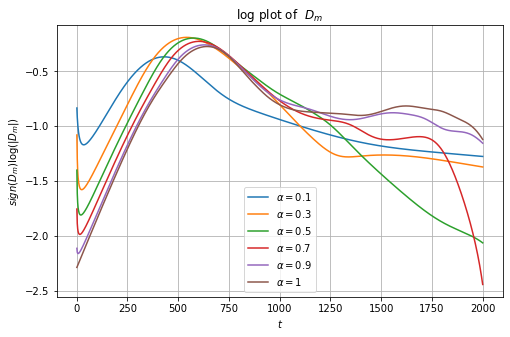

In [106]:
t = np.linspace(1,2000, 2000)
plt.figure(figsize=(8,5))
# plt.yscale('symlog')
# plt.xscale('symlog')
# plt.plot(t, mass_1)
# plt.plot(t, mass_2)
# plt.plot(t, mass_3)
# plt.plot(t, mass_4)
# plt.plot(t, mass_5)
plt.plot(t,Y)
plt.legend([rf"$\alpha=${alpha}" for alpha in alpha_list])
plt.title(r'log plot of  $D_m$')
plt.ylabel(r'$sign(D_m)\log(\vert D_m\vert)$')
plt.xlabel(r'$t$')
plt.grid()
plt.show()

In [9]:
# test the gaussian fit for coarsening
from scipy.optimize import curve_fit

def func1(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def func2(x, x0, g, a):
    return a*g/((x-x0)**2+g**2)

t = np.linspace(1, 5000, 5000)

beta0 = []
beta1 = []
beta2 = []
for i in range(len(alpha_list)):
    popt, pcov = curve_fit(func2, t, DifferecneMass[:,i],maxfev = 10000)
    print('peak position: ', popt[0])
    print('width size: ', popt[1])
    print('high size: ', popt[2])
    print('alpha: ', alpha_list[i])
    beta0.append(popt[0])
    beta1.append(popt[1])
    beta2.append(popt[2])
#     ym = func1(t, popt[0], popt[1], popt[2])
    ym = func2(t, popt[0], popt[1], popt[2])
    plt.plot(t, DifferecneMass[:,i], '.')
    plt.plot(t, ym)
    plt.legend(['exact', 'fit'])
    plt.show()

NameError: name 'DifferecneMass' is not defined

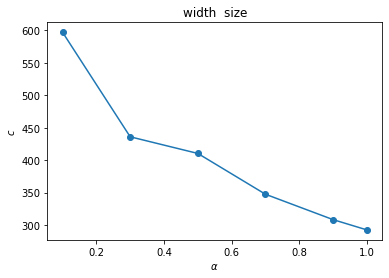

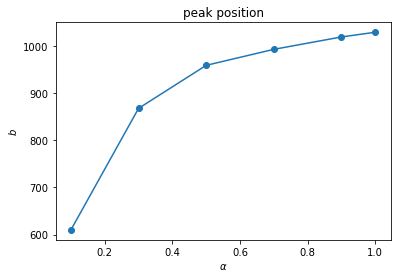

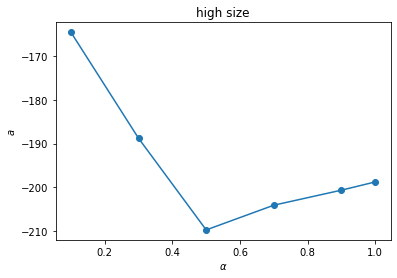

In [113]:
plt.plot(alpha_list, beta1, 'o-')
plt.title('width  size')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$c$')
plt.show()
plt.plot(alpha_list, beta0, 'o-')
plt.title('peak position')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$b$')
plt.show()
plt.plot(alpha_list, beta2, 'o-')
plt.title('high size')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$a$')
plt.show()

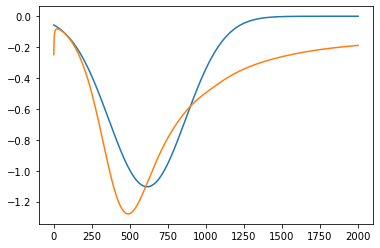

In [217]:
ym = func(t, popt[0], popt[1], popt[2])
plt.plot(t, ym)
plt.plot(t, Y[:,1])

In [10]:
# save the test data
from pathlib import Path
import time

ts = str(time.time())
rootPath = Path('./data/'+ts)

if rootPath.exists() is False:
    rootPath.mkdir(parents=True)

    for alpha, u_historyArray in data_dict.items():
        dataPath = rootPath / Path(f'L1_{alpha}_coarsening.npy')
        np.save(dataPath, u_historyArray)

In [94]:
circle_dict = {}

idx_time_list = [100, 750, 1500, 2250, 3000]
for alpha in alpha_list:
    area_list = []
    for idx_time in idx_time_list:
        points = (data_dict[alpha][idx_time] > 0.5).sum()
        if points != 0:
            area = points*h**2
        else:
            area = 0
        area_list.append(area)
    circle_dict[alpha] = area_list

In [101]:
iter_max = 1200
idx_time_points = np.linspace(0, iter_max, 10, dtype = int)
idx_time_points

array([   0,  133,  266,  400,  533,  666,  800,  933, 1066, 1200])

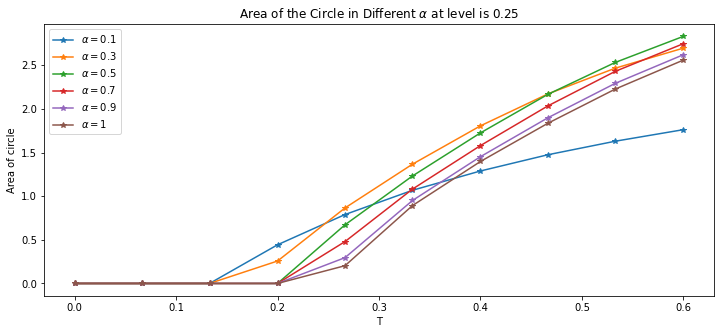

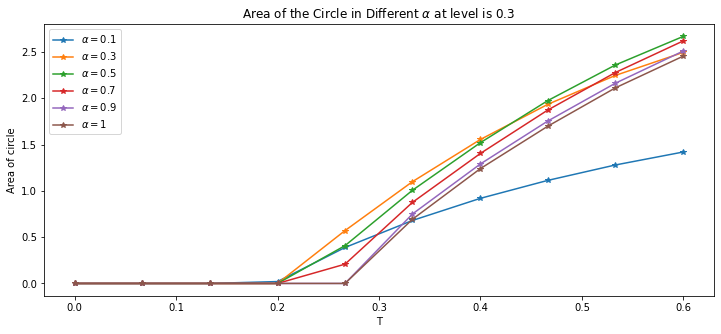

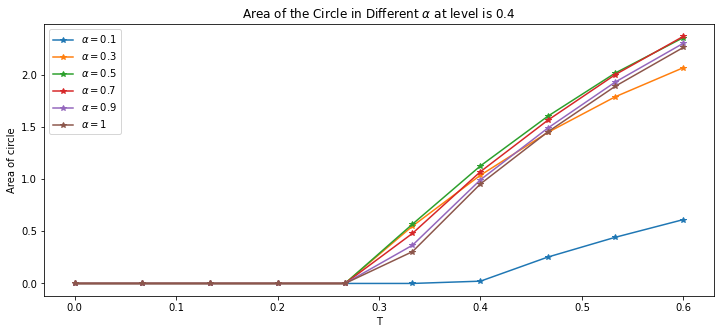

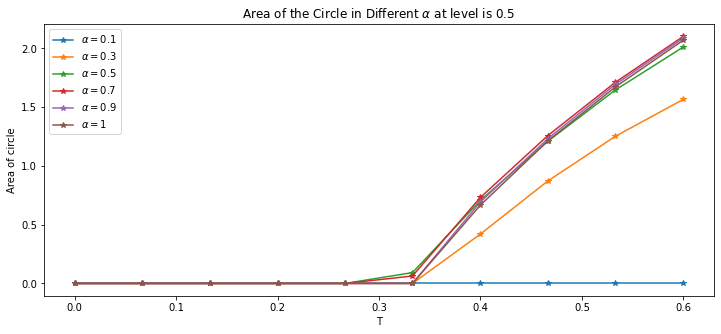

In [103]:
circle_dict = {}

idx_time_points = np.linspace(0, iter_max, 10, dtype = int)
levels = [0.25, 0.3, 0.4, 0.5] 
for level in levels:
    circle_dict = {}
    for alpha in alpha_list:
        area_list = []
        for idx_time in idx_time_points:
            points = (data_dict[alpha][idx_time] > level).sum()
            if points != 0:
                area = points*h**2
            else:
                area = 0
            area_list.append(area)
        circle_dict[alpha] = area_list


    time = [_*dt for _ in idx_time_points]
    
    plt.figure(figsize=(12,5))
    for alpha, area in circle_dict.items():
        plt.plot(time, area, '*-')


    plt.legend([rf"$\alpha=${alpha}" for alpha in alpha_list])
    plt.xlabel('T')
    plt.ylabel('Area of circle')
    plt.title(fr'Area of the Circle in Different $\alpha$ at level is {level}')
    plt.show()

In [85]:
circle_dict

{0.1: [], 0.3: [], 0.5: [], 0.7: [], 0.9: [], 1: []}

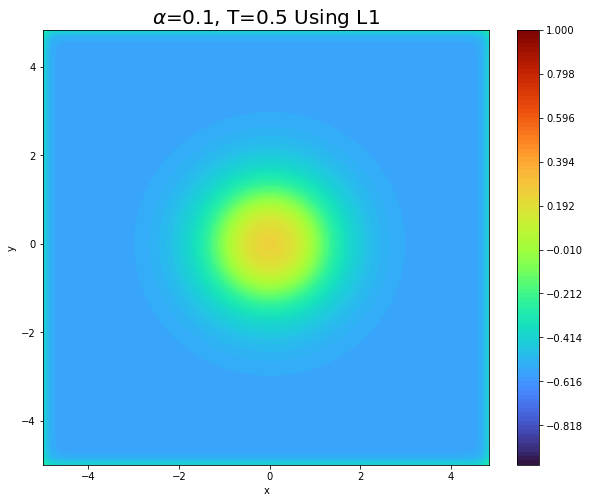

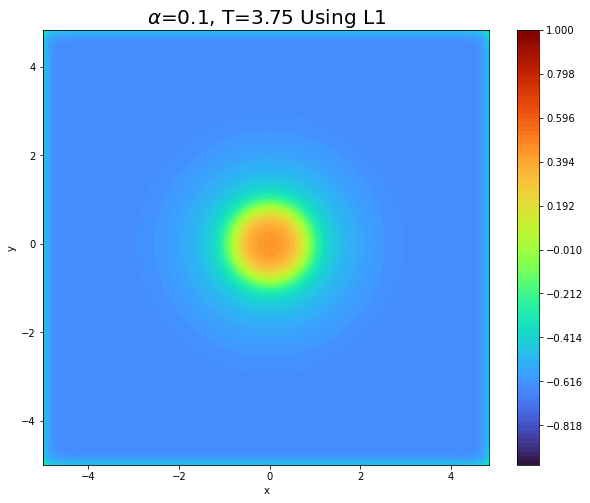

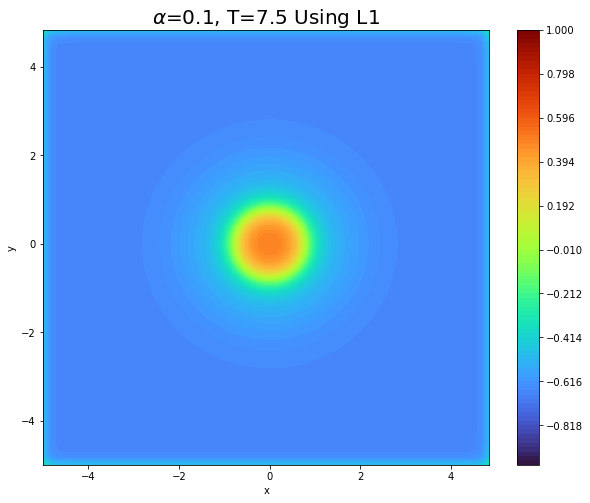

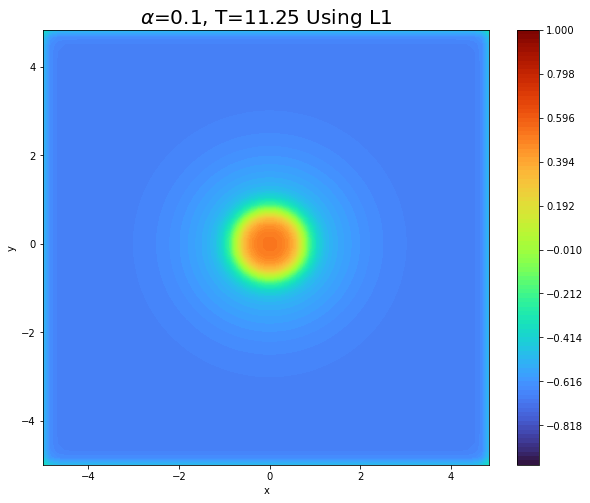

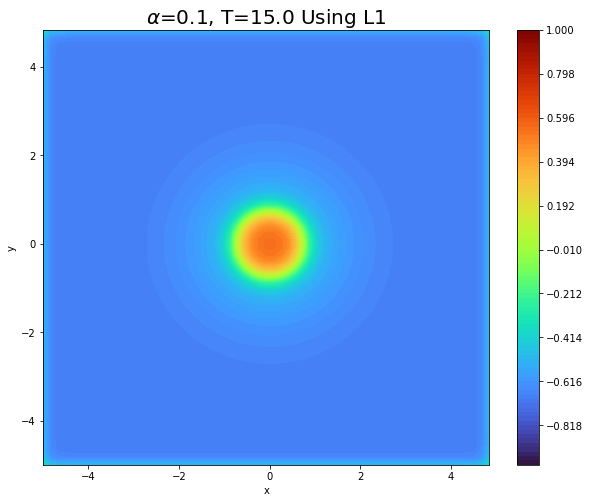

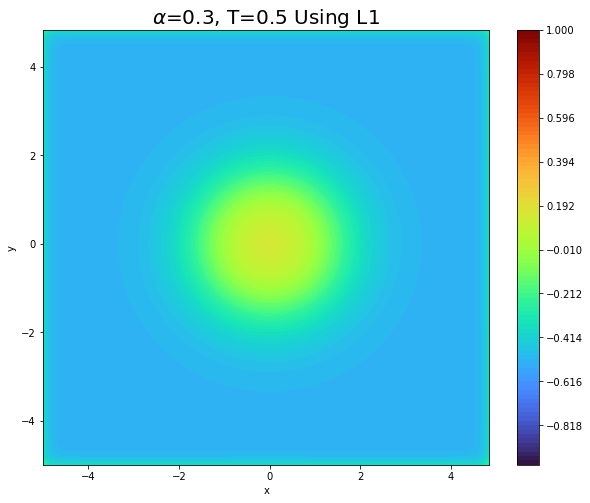

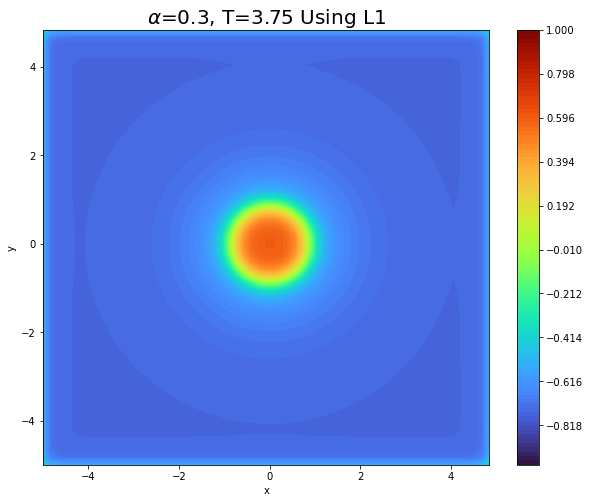

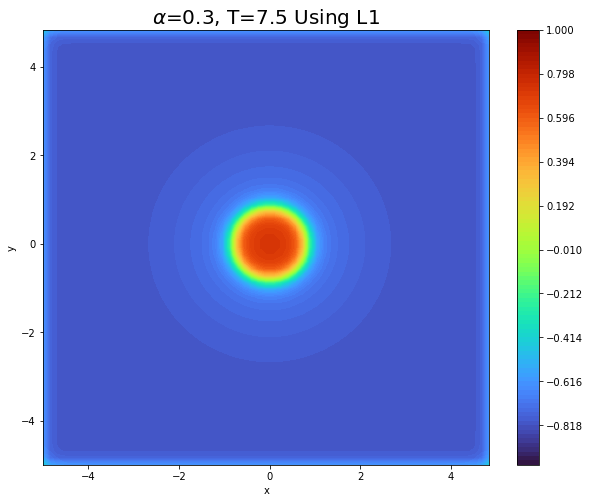

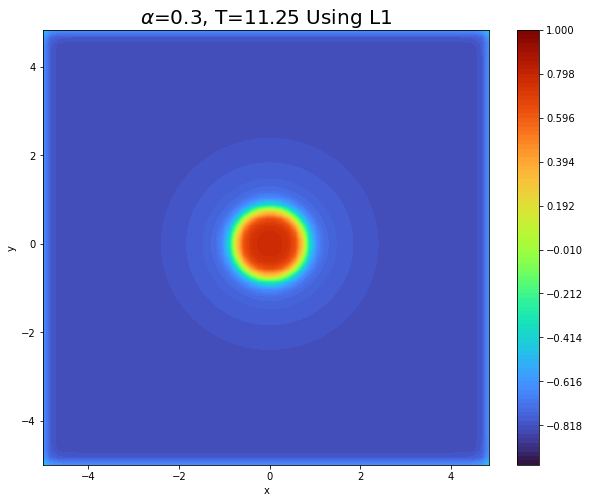

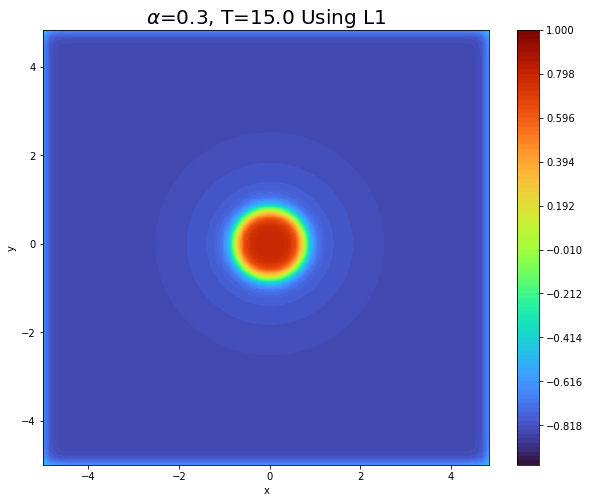

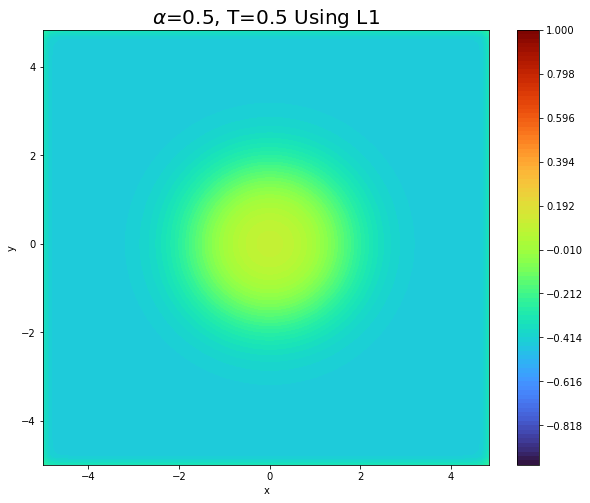

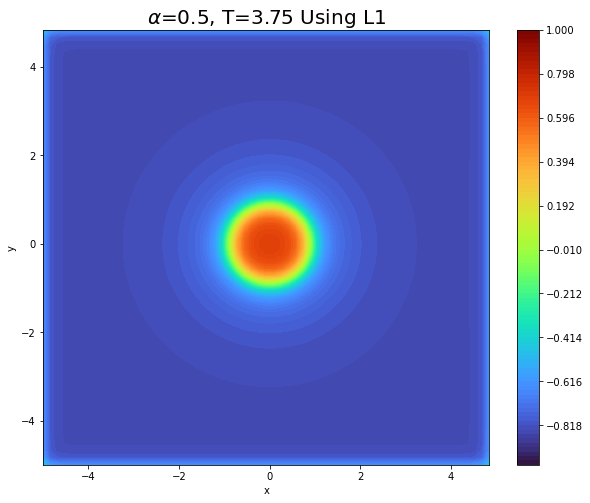

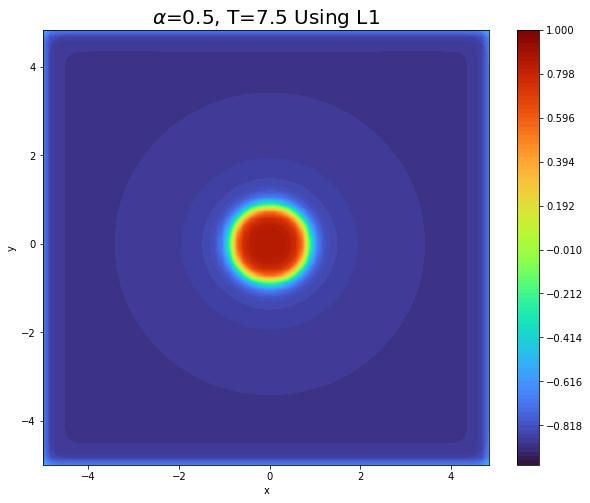

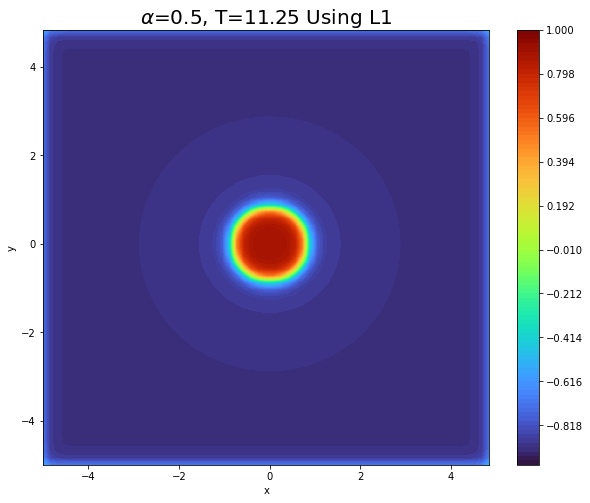

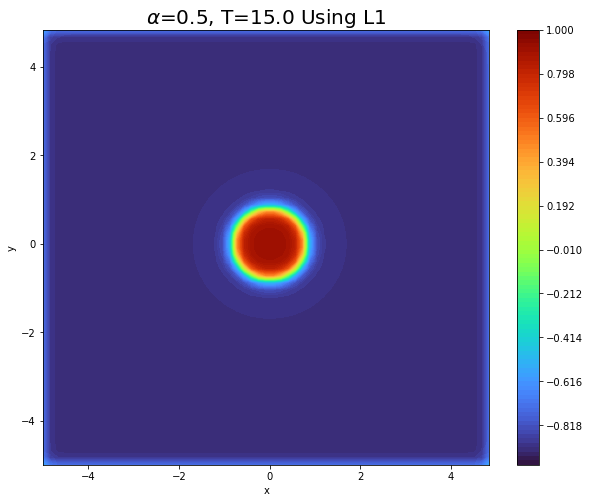

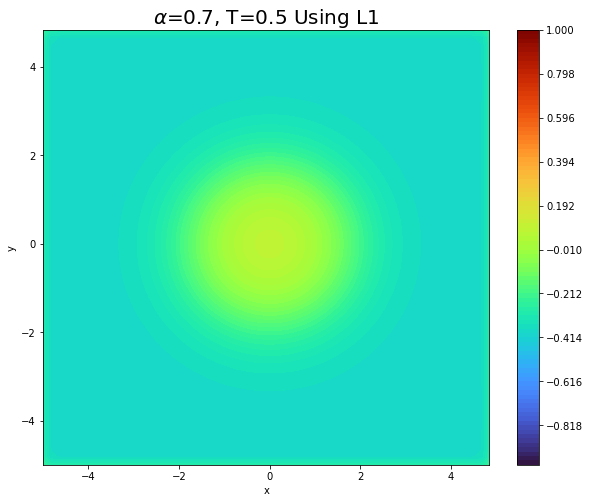

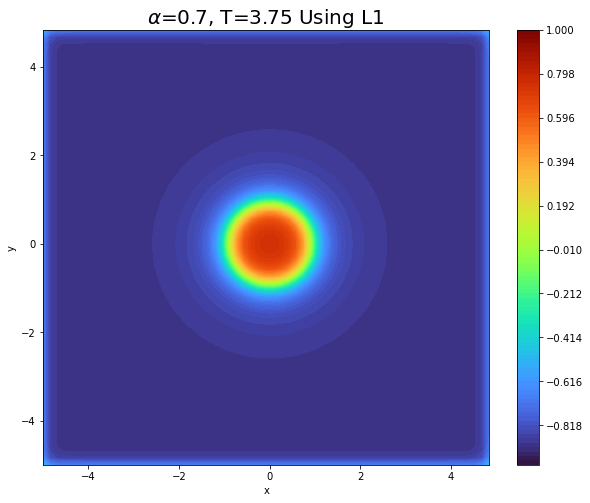

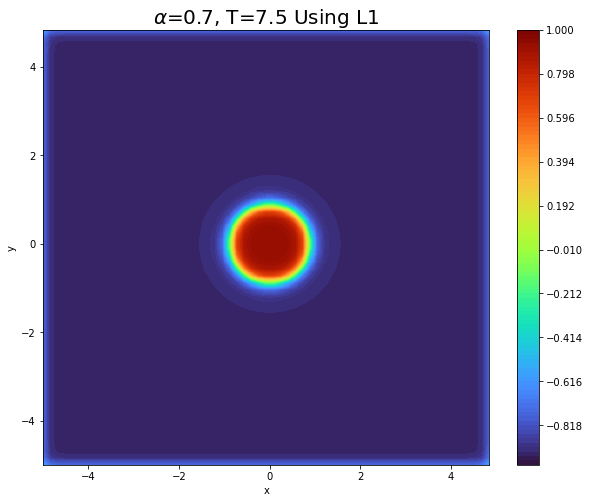

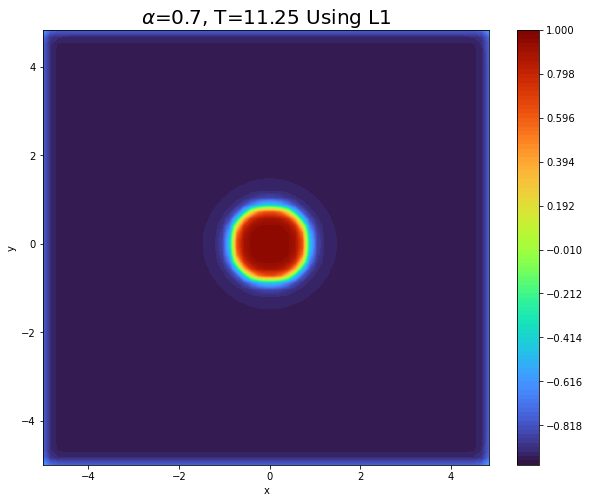

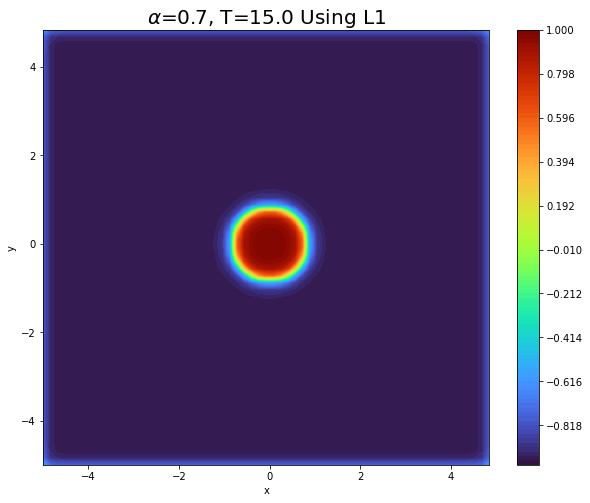

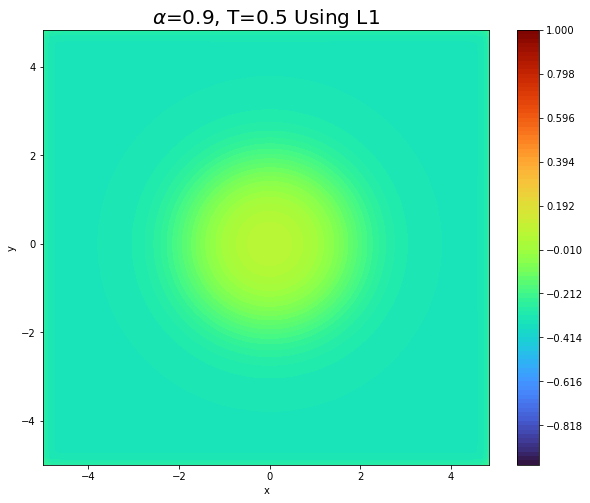

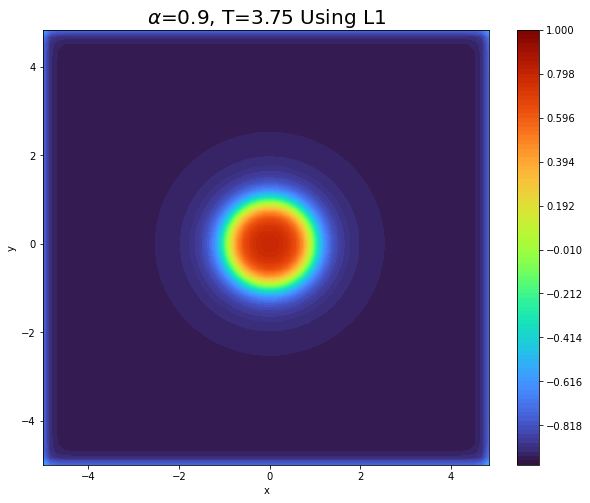

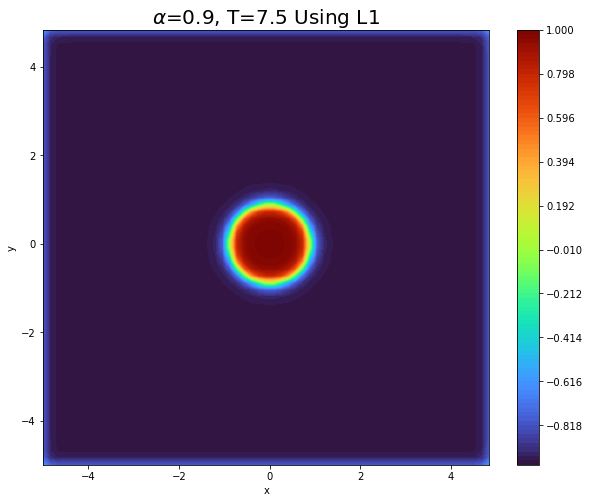

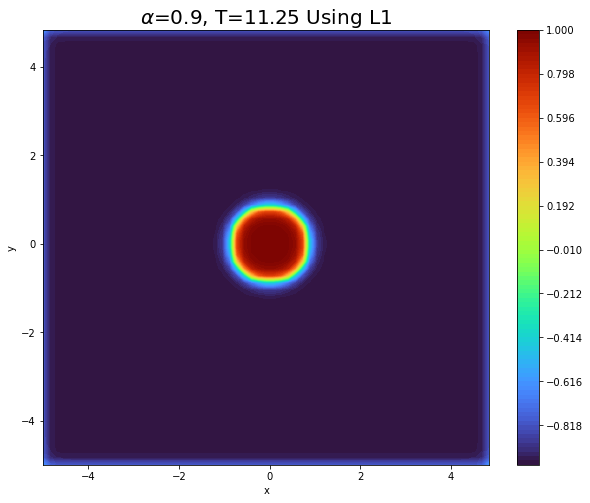

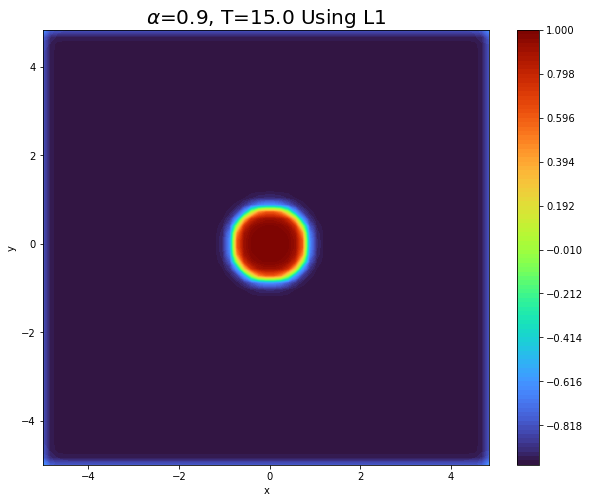

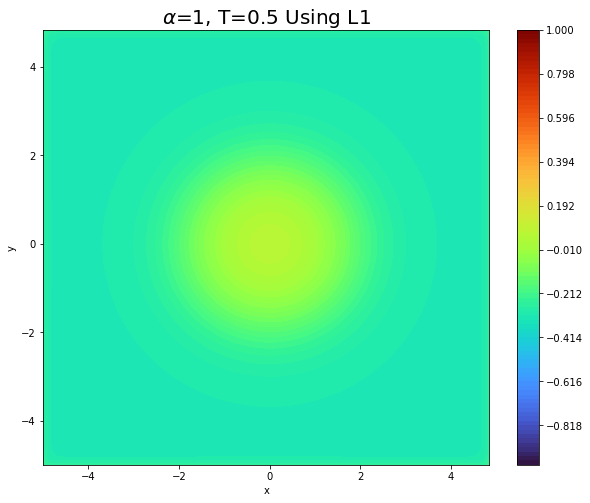

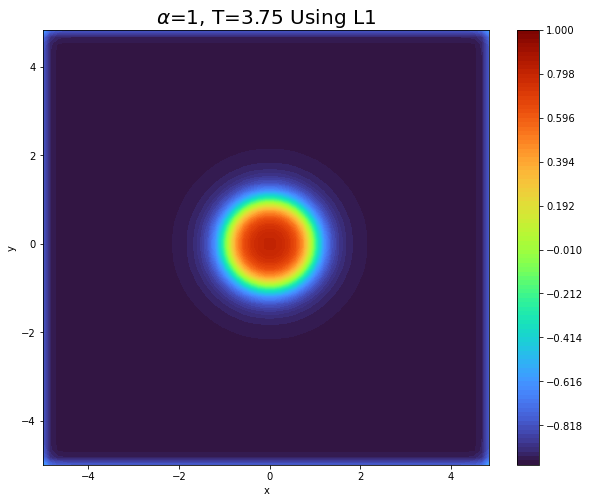

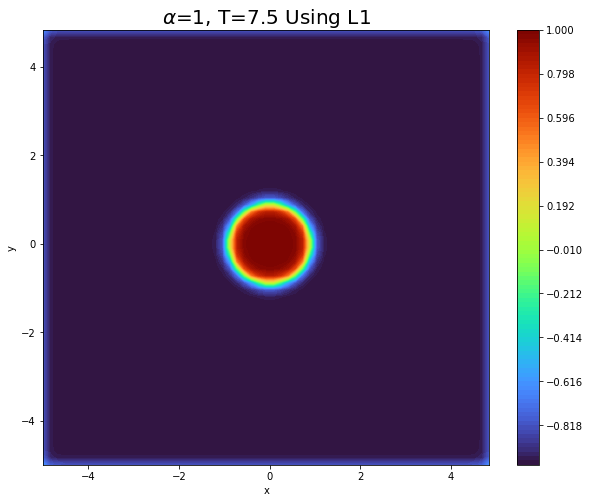

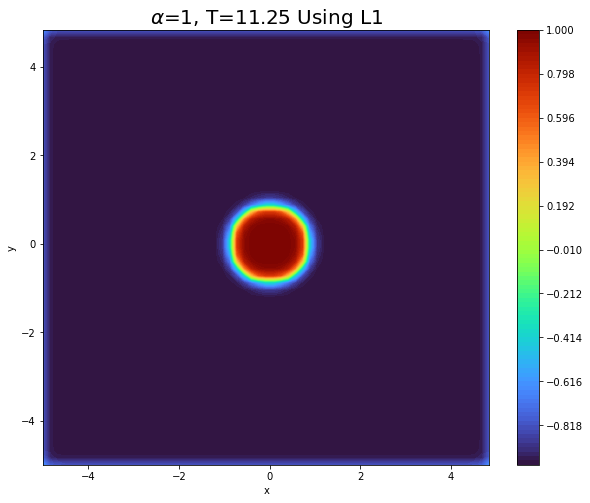

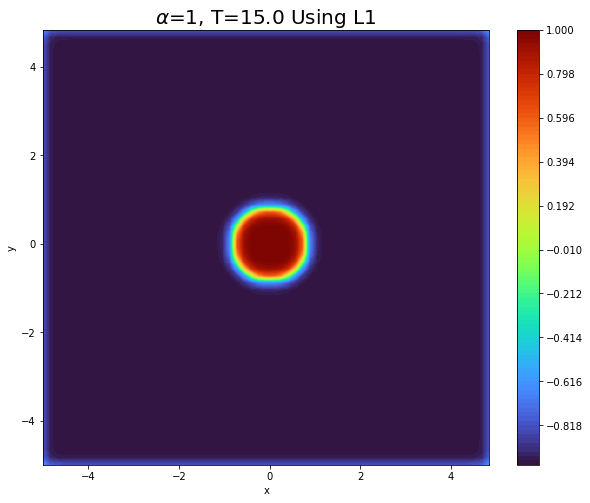

In [106]:
for alpha in alpha_list:
    for idx_time in idx_time_list:
        plt.figure(figsize=(10,8))
        plt.contourf(X,Y, np.reshape(data_dict[alpha][idx_time], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
        plt.colorbar()
        plt.title(rf'$\alpha$={alpha}, T={idx_time*dt} Using L1', fontsize=20)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

In [65]:
data_dict[.3][750][data_dict[.3][750] > 0.5]

array([0.52670525, 0.54981908, 0.54981908, 0.52670525, 0.52670525,
       0.56874273, 0.58423263, 0.58423263, 0.56874273, 0.52670525,
       0.54981908, 0.58423263, 0.59680273, 0.59680273, 0.58423263,
       0.54981908, 0.54981908, 0.58423263, 0.59680273, 0.59680273,
       0.58423263, 0.54981908, 0.52670525, 0.56874273, 0.58423263,
       0.58423263, 0.56874273, 0.52670525, 0.52670525, 0.54981908,
       0.54981908, 0.52670525])

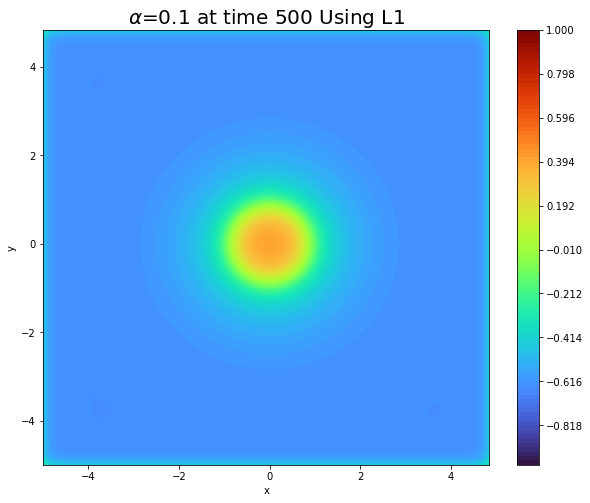

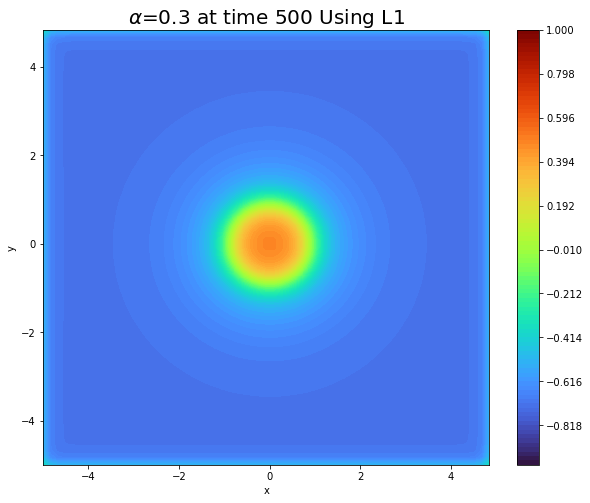

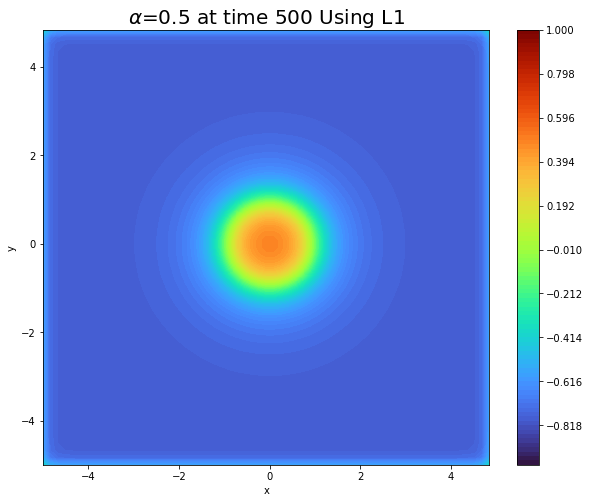

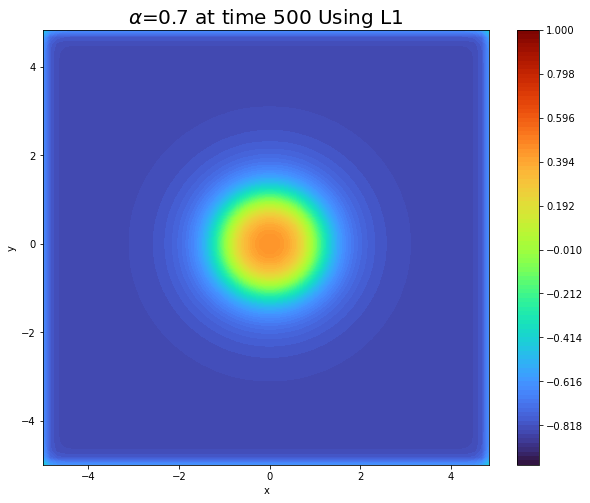

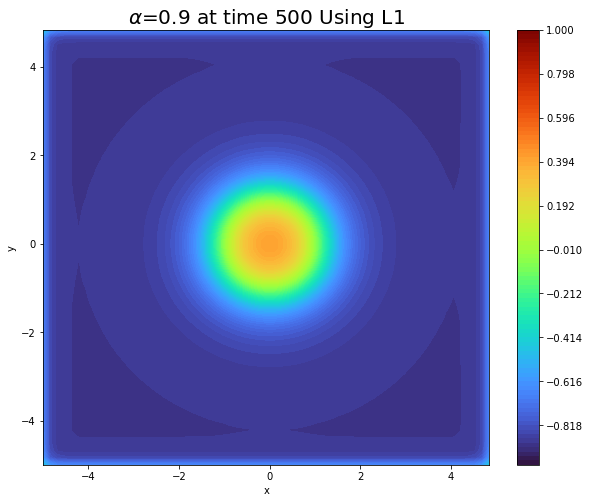

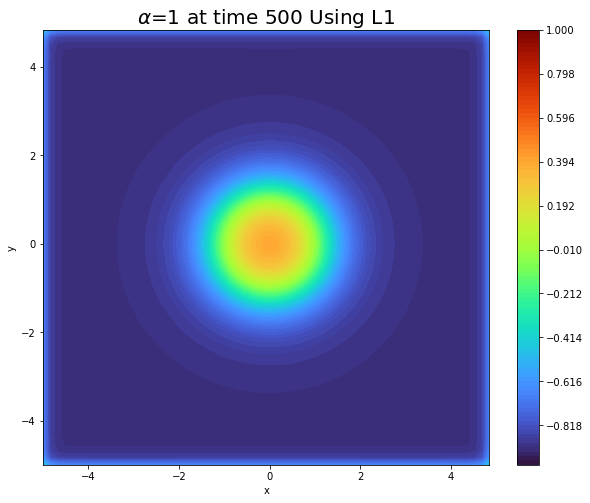

In [102]:
plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[0.1][500], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=0.1 at time 500 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[0.3][500], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=0.3 at time 500 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[0.5][500], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=0.5 at time 500 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[0.7][500], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=0.7 at time 500 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[0.9][500], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=0.9 at time 500 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[1][500], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=1 at time 500 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

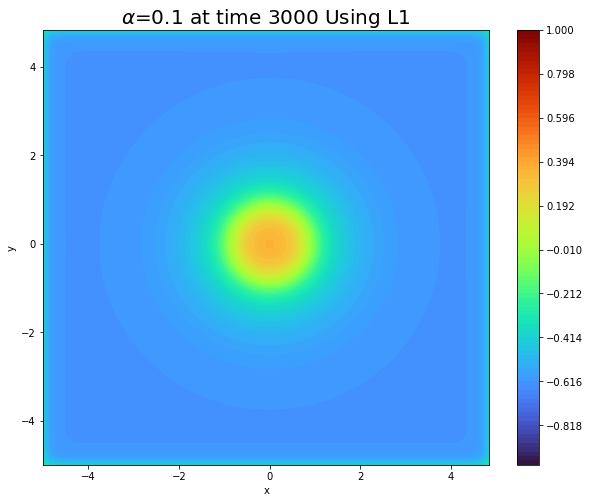

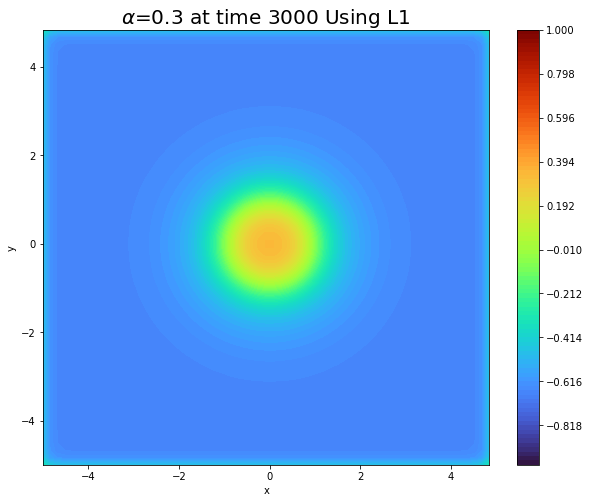

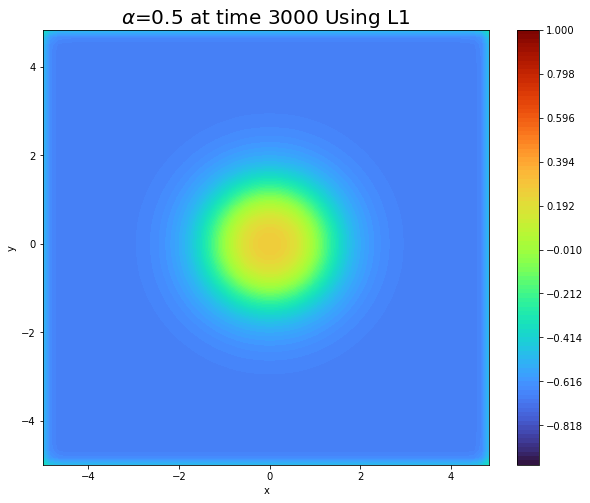

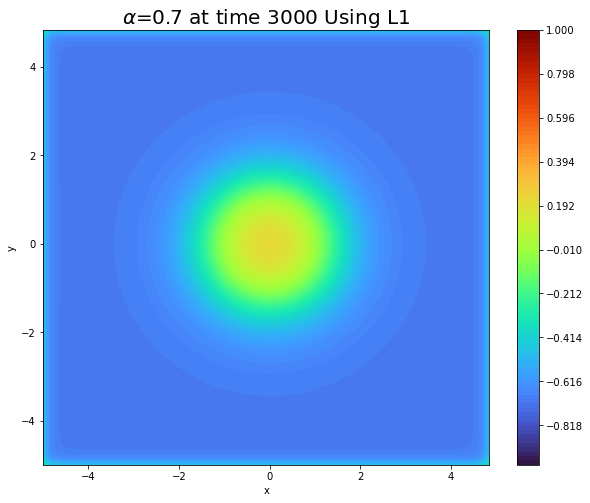

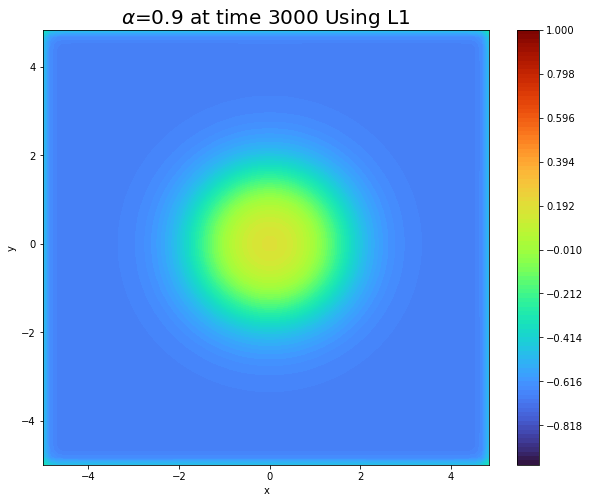

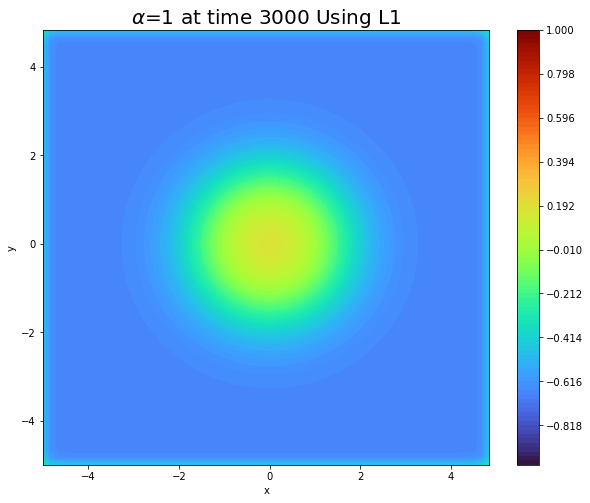

In [57]:
plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[0.1][-1], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=0.1 at time 3000 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[0.3][-1], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=0.3 at time 3000 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[0.5][-1], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=0.5 at time 3000 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[0.7][-1], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=0.7 at time 3000 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[0.9][-1], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=0.9 at time 3000 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[1][-1], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'$\alpha$=1 at time 3000 Using L1', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

8072
8312


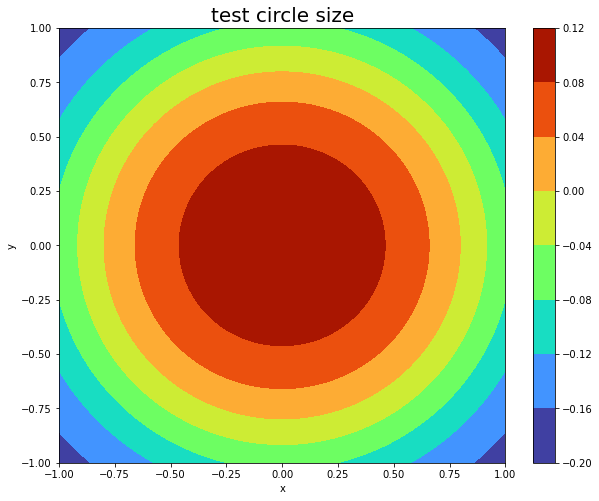

In [76]:
L = 2
# determine the number of point in x or y direction
Nx = 2**7
x = np.linspace(-L/2, L/2, Nx) 
y = np.linspace(-L/2, L/2, Nx)

# compute the mesh size
h = L / (Nx - 1)
dt = 5*1e-4
iter_max = 2000


# set the 2D mesh grid by x and y
X, Y = np.meshgrid(x, y)

# nonsmooth test
# u = 0.05*(2*np.random.rand(Nx-1, Nx-1)-1)

# smooth test
u = np.tanh((L**2/(2*np.pi)-((X)**2+(Y)**2)))*0.2

print(np.sum(u>0))
print(np.sum(u<0))

plt.figure(figsize=(10,8))
plt.contourf(X,Y, u, cmap="turbo")
plt.colorbar()
plt.title(r'test circle size', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

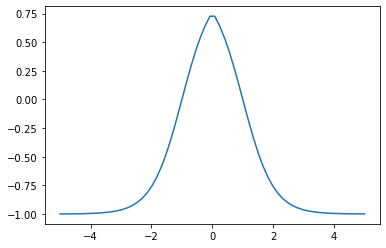

In [46]:
z0 = np.tanh((1-np.abs(x)))*1
z1 = np.tanh((1-np.abs(x))/5)*1
z2 = np.tanh((1-np.abs(x))/10)*1
plt.plot(x,z0)
plt.plot(x,z1)
plt.plot(x,z2)

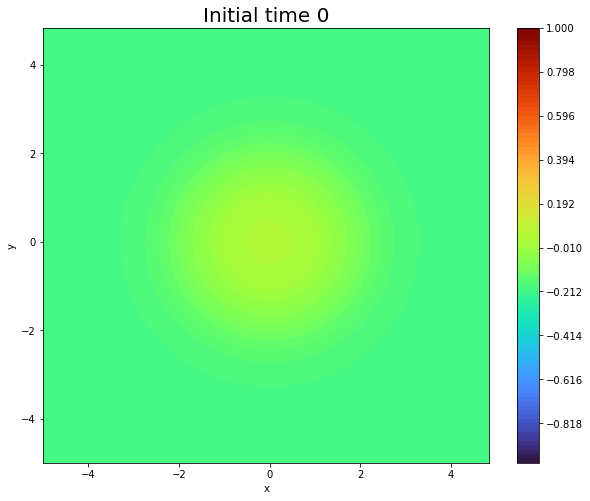

In [49]:
plt.figure(figsize=(10,8))
plt.contourf(X,Y, np.reshape(data_dict[1][0], (Nx-1,Nx-1)), cmap="turbo",levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'Initial time 0', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [51]:
L = 10
Nx = Ny = 2**6
x = np.linspace(-L/2, L/2, Nx)
y = np.linspace(-L/2, L/2, Ny)
x = x[:-1]
y = y[:-1]
# u = np.cos(x)

X, Y = set_meshgrid(x, y)
Z = np.cos(X + Y)
# print(np.cos(X + Y))

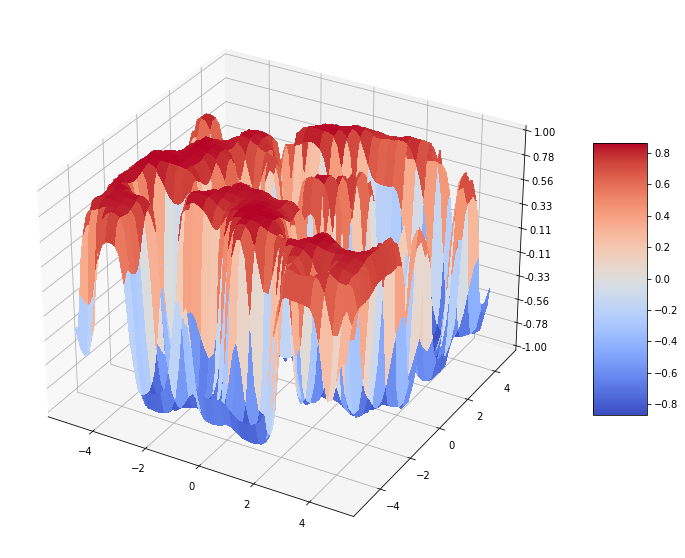

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(figsize=(15,10),subplot_kw={"projection": "3d"})
Z = np.reshape(data_dict[0.5][-1], (Nx-1,Nx-1))
# Z = np.tanh((1-((X)**2+(Y)**2))/5)*0.2


# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [26]:
from scipy.optimize import minimize, LinearConstraint
import numpy as np
from scipy.sparse.linalg import eigs
def fun1(x, p, dt, eps, eig):
    y = x - dt*(eps**2*eig*(p+x) +p -(p+x)**3)
    return y

def fun2(x, p, dt, c):
    y = x - dt*(c +p -(p+x)**3)
    return y

def fun3(x, p, dt, eps):
    return x - dt*(eps**2*(p[0]-2*p[1]-x+p[2])+p[1]-(p[1]-x)**3)

def fun4(x, p, dt, eps):
    return x - dt*(eps**2*(-4*p[0]+p[1]+p[2]+p[3]+p[4]+x)+p[0]-(p[0]+x)**3)

def fun5(x,p,dt,eps,k):
    return x-dt*((eps**2*k-2)*(p+x)+3*p-p**3)

eps = 1
Nx = 2**5
x = np.linspace(-1,1,100)

h = 1 / (Nx - 1)
dt = 0.1
lap = set_Laplacian2D(Nx,h)
eigs,_ = eigs(-lap)
Meig = max(eigs)
# eig = 4/h**2
# max_eig = 0
print(np.real(Meig))
p = 0.01

7669.490089327962


In [168]:
solution = fsolve(fun1, 0, args=(p, dt, eps, eig))
solution

array([-0.01017318])

In [51]:
y = fun1(x, p, dt,eps,4/h**2)

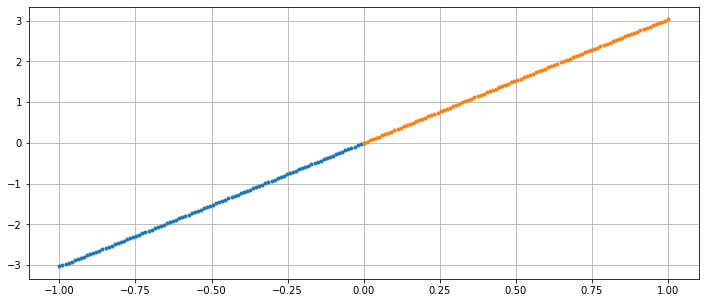

In [28]:
pos_p = np.linspace(0,1,100)
neg_p = np.linspace(-1,0,100)
roots = []
# roots = [fsolve(fun2,0,args=(neg_p[i],dt,-0.001)) for i in range(len(neg_p))]
pos_roots = [fsolve(fun5, 0, args=(pos_p[i], 0.01, 0.1, np.real(Meig))) for i in range(len(pos_p))]
neg_roots = [fsolve(fun5, 0, args=(neg_p[i], 0.01, 0.1, np.real(Meig))) for i in range(len(neg_p))]

plt.figure(figsize=(12,5))
plt.plot(neg_p, neg_roots,'.')
plt.plot(pos_p, pos_roots,'.')
plt.grid()
plt.show()

In [3]:
# rng = 0.05*(2*np.random.rand(1)-1)
pos_roots = [fsolve(fun4, 0, args=([pos_p[i], pos_p[i]+0.05*(2*np.random.rand(1)-1), pos_p[i]+0.05*(2*np.random.rand(1)-1), pos_p[i]+0.05*(2*np.random.rand(1)-1), pos_p[i]+0.05*(2*np.random.rand(1)-1)], 0.1, eps)) for i in range(len(pos_p))]
# pos_roots = [fsolve(fun4, 0, args=([pos_p[i], 0.05*(2*np.random.rand(1)-1), 0.05*(2*np.random.rand(1)-1), 0.05*(2*np.random.rand(1)-1), 0.05*(2*np.random.rand(1)-1)], 0.000001, 0.1)) for i in range(len(pos_p))]
neg_roots = [fsolve(fun3, 0, args=([neg_p[i], neg_p[i], neg_p[i], neg_p[i], neg_p[i]], 0.01, eps)) for i in range(len(neg_p))]

plt.figure(figsize=(12,5))
# plt.plot(neg_p, neg_roots,'.')
plt.plot(pos_p, pos_roots,'.')
plt.legend(['negative', 'positive'])
plt.title(r'root of $x-dt(\epsilon^2(p_{i-1}-2p_i+p_{i+1}+x)+p_i-(p_i-x)^3)$')
plt.xlabel('p')
plt.ylabel('x')
plt.grid()
plt.show()

NameError: name 'pos_p' is not defined

C:\Users\user\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


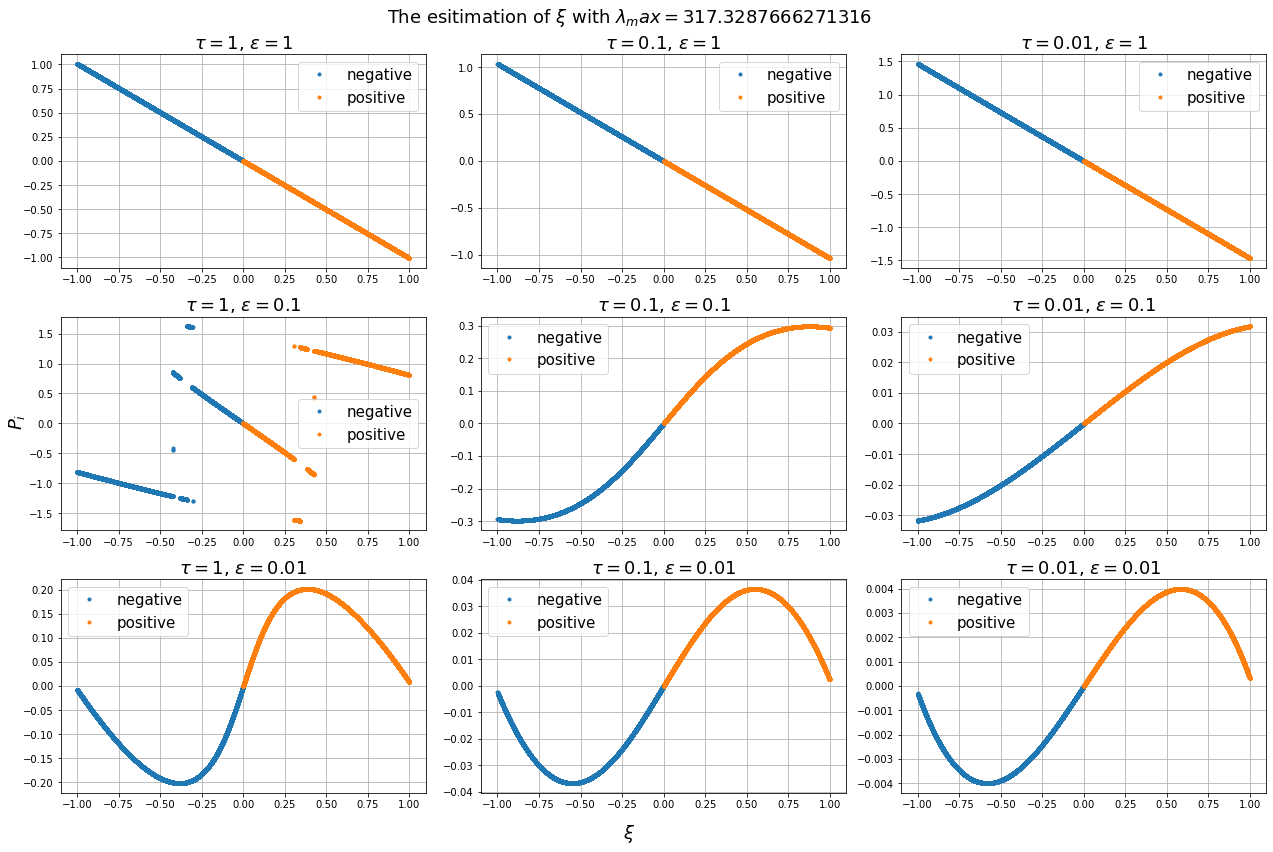

In [22]:
def fun4(x, p, dt, eps ,k):
    return x - dt*(eps**2*k*(p+x)+p-(p+x)**3)

pos_p = np.linspace(0,1,10000)
neg_p = np.linspace(-1,0,10000)

test_data_set = {
    'dt': [1, 0.1, 0.01],
    'eps': [1, 0.1, 0.01],
#     'pos_p': [np.hstack((p, 0.05*(2*np.random.rand(4)-1))) for p in pos_p] ,
#     'neg_p': [np.hstack((p, 0.05*(2*np.random.rand(4)-1))) for p in neg_p]
    'pos_p': pos_p,
    'neg_p': neg_p
}

fun_plot = plt.figure(figsize=(18,12))
fun_plot_space = gridspec.GridSpec(3, 3, figure=fun_plot)
gs_idx = [(0,0), (1,0), (2,0), (0,1), (1,1), (2,1), \
          (0,2), (1,2), (2,2)]
L = 10
# determine the number of point in x or y direction
Nx = 2**6

# compute the mesh size
h = L / (Nx - 1)
# k = 4/h**2
Lap = set_Laplacian2D(Nx, h)
k, _ = eigs(-Lap)
k = np.max(np.real(k))
pos_roots = []
neg_roots = []
i = 0
for dt in test_data_set['dt']:
    for eps in test_data_set['eps']:
        
        pos_roots = [fsolve(fun4, p, args=(p, dt, eps, k)) for p in test_data_set['pos_p']]
        neg_roots = [fsolve(fun4, p, args=(p, dt, eps, k)) for p in test_data_set['neg_p']]
        
        ax = plt.subplot(fun_plot_space[gs_idx[i]])
        ax.plot(neg_p, neg_roots,'.')
        ax.plot(pos_p, pos_roots,'.')
        ax.legend(['negative', 'positive'], prop={'size': 15})
        ax.set_title(rf'$\tau=${dt}, $\epsilon=${eps}', fontsize=18)
        ax.grid()
        i = i+1
#         plt.plot(neg_p, neg_roots,'.')
#         plt.plot(pos_p, pos_roots,'.')
#         plt.legend(['negative', 'positive'], prop={'size': 15})
#         plt.title(f'$dt=${dt}, $\epsilon=${eps}', fontsize=18)
#         plt.xlabel('p')
#         plt.ylabel('x')
#         plt.grid()

fun_plot.suptitle(rf"The esitimation of $\xi$ with $\lambda_max=${k}", fontsize= 18)
fun_plot.supxlabel(r'$\xi$', fontsize= 18)
fun_plot.supylabel(r"$P_i$", fontsize= 18)
plt.tight_layout(rect=(0,0,1,1))
plt.show()

In [14]:
Lap = set_Laplacian2D(Nx, h)
k,_ = eigs(-Lap)
print(k)

[317.32876663+0.j 316.75552721+0.j 317.04214692+0.j 317.04214692+0.j
 316.56521467+0.j 316.56521467+0.j]


In [14]:
from scipy.special import gamma, binom
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
def test_fractional_fun(x, p, dm, dt, eps, alpha, k):
    c1 = 2**(1-alpha) - 1**(1-alpha)
    c2 = 3**(1-alpha) - 1**(2-alpha)
    return x + c1*dm - dt*gamma(2-alpha)*(eps**2*k*(p+x)+p-(p+x)**3)


dt = 0.1
eps = 0.1
pos_p = np.linspace(0,1,100)
neg_p = np.linspace(-1,0,100)
alpha = 0.5
dm = -1
pos_p = np.linspace(0,1,1000)
neg_p = np.linspace(-1,0,1000)
# pos_list = [np.hstack((p, 0.05*(2*np.random.rand(4)-1))) for p in pos_p]
# neg_list = [np.hstack((p, 0.05*(2*np.random.rand(4)-1))) for p in neg_p]

pos_roots1 = [fsolve(test_fractional_fun, 0.0, args=(p, dm, dt, eps, alpha, k)) for p in pos_p]
neg_roots1 = [fsolve(test_fractional_fun, 0.0, args=(p, dm, dt, eps, alpha, k)) for p in neg_p]

dm = 1

pos_roots2 = [fsolve(test_fractional_fun, 0.0, args=(p, dm, dt, eps, alpha, k)) for p in pos_p]
neg_roots2 = [fsolve(test_fractional_fun, 0.0, args=(p, dm, dt, eps, alpha, k)) for p in neg_p]

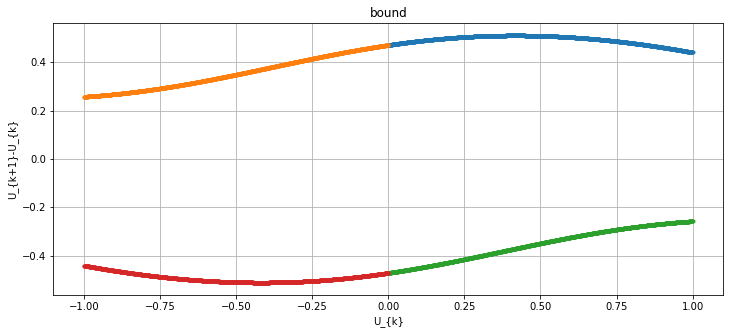

In [19]:
plt.figure(figsize=(12,5))
plt.plot(pos_p, pos_roots1, '.')
plt.plot(neg_p, neg_roots1, '.')
plt.plot(pos_p, pos_roots2, '.')
plt.plot(neg_p, neg_roots2, '.')
plt.grid()
plt.title('bound')
plt.ylabel('U_{k+1}-U_{k}')
plt.xlabel('U_{k}')
plt.show()